In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.options.display.float_format = "{:,.2f}".format


In [56]:
train_df = pd.read_parquet("FY24FY25.parquet")
test_df  = pd.read_parquet("FY26.parquet")

df = pd.concat([train_df, test_df], ignore_index=True)

print("Shape:", df.shape)
df.head()


Shape: (2986151, 24)


,ANSR / Tech Revenue FYTD,AR Outstanding,Billed Expenses FYTD,Billed Fees FYTD,Billed Revenue Days,Charged Hours FYTD,Client,Client ID,EAF Reserve FYTD,ETD Total Collections,Engagement Partner,Engagement Sub Service Line,Expenses FYTD,FYTD Collections,FYTD Labor Costs,FYTD Unbilled Expenses,Location,MS,NUI ETD,Total Billed FYTD,Unbilled Revenue Days,Month,Week,Year
0,0.00,0.00,0.00,0.00,0.00,0.00,QUEST GLOBAL SERVICES PTE. LTD.,11421164,0.00,0.00,"Ghosh, Subh",Audit,0.00,0.00,0.00,0.00,Bangalore,TMT,0.00,0.00,0.00,03 Sep,10,FY24
1,0.00,0.00,0.00,0.00,0.00,0.00,Industrial Energy Limited,11881305,0.00,0.00,"Agarwal, Sanjay",Audit,0.00,0.00,0.00,0.00,East,IIC,0.00,0.00,0.00,03 Sep,10,FY24
2,0.00,0.00,0.00,0.00,0.00,0.00,Vini Cosmetics Private Limited,11453641,0.00,0.00,"Kalia, Chaitanya",CCaSS,0.00,0.00,0.00,0.00,Mumbai,IIC,0.00,0.00,0.00,03 Sep,10,FY24
3,0.00,0.00,0.00,0.00,0.00,0.00,UNIPHORE SOFTWARE SYSTEMS PRIVATE LIMITED,12239544,0.00,0.00,"Agrawal, Ayush",FAAS,0.00,0.00,0.00,0.00,Delhi,TMT,0.00,0.00,0.00,03 Sep,10,FY24
4,0.00,0.00,0.00,0.00,0.00,0.00,THE TATA POWER COMPANY LIMITED,11230405,0.00,0.00,"Kalia, Chaitanya",CCaSS,0.00,0.00,0.00,0.00,Mumbai,IIC,0.00,0.00,0.00,03 Sep,10,FY24


In [57]:
weekly_fytd = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
)

weekly_fytd = weekly_fytd[weekly_fytd["Week"].between(1, 52)]


In [72]:
def extract_fy(df, fy):
    return (
        df[df["Year"].astype(str).str.contains(fy)]
        [["Week", "ANSR / Tech Revenue FYTD"]]
        .rename(columns={"ANSR / Tech Revenue FYTD": f"FY{fy}_FYTD"})
    )


fy24 = extract_fy(weekly_fytd, "24")
fy25 = extract_fy(weekly_fytd, "25")
fy26 = extract_fy(weekly_fytd, "26")


In [73]:
fy25_plot = fy25.sort_values("Week").copy()

fy25_plot.loc[fy25_plot["Week"] < 3, "FY25_FYTD"] = np.nan

w = 34
fy25_plot.loc[fy25_plot["Week"] == w, "FY25_FYTD"] = (
    fy25_plot.loc[fy25_plot["Week"] == w-1, "FY25_FYTD"].values[0] +
    fy25_plot.loc[fy25_plot["Week"] == w+1, "FY25_FYTD"].values[0]
) / 2


In [74]:
weeks = pd.DataFrame({"Week": range(1, 53)})

fytd_table = (
    weeks
    .merge(fy24, on="Week", how="left")
    .merge(fy25_plot, on="Week", how="left")
    .merge(fy26, on="Week", how="left")
)

fytd_table.columns = [
    "Week", "FY24_FYTD", "FY25_FYTD", "FY26_FYTD"
]


In [75]:
inc_df = fytd_table.copy()

for fy in ["FY24", "FY25", "FY26"]:
    inc_df[f"{fy}_Weekly_Inc"] = inc_df[f"{fy}_FYTD"].diff()
    inc_df.loc[inc_df["Week"] == 1, f"{fy}_Weekly_Inc"] = inc_df.loc[
        inc_df["Week"] == 1, f"{fy}_FYTD"
    ]


In [76]:
for col in ["FY24_Weekly_Inc", "FY25_Weekly_Inc"]:
    inc_df[col] = inc_df[col].interpolate(limit_area="inside")


In [77]:
for fy in ["FY24", "FY25", "FY26"]:
    inc_df[f"{fy}_WoW_%"] = inc_df[f"{fy}_Weekly_Inc"].pct_change()

wow_train = pd.concat([
    inc_df["FY24_WoW_%"],
    inc_df["FY25_WoW_%"]
]).replace([np.inf, -np.inf], np.nan).dropna() / 100


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_24372\3866012034.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  inc_df[f"{fy}_WoW_%"] = inc_df[f"{fy}_Weekly_Inc"].pct_change()


In [78]:
model = SARIMAX(wow_train, order=(2,0,1))
fit = model.fit(disp=False)

forecast = fit.get_forecast(steps=12)
wow_mean = forecast.predicted_mean
wow_ci = forecast.conf_int()


c:\Users\FV586VH\Downloads\VSC\Model\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\FV586VH\Downloads\VSC\Model\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\FV586VH\Downloads\VSC\Model\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\FV586VH\Downloads\VSC\Model\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is avai

In [79]:
last_actual_week = 13
prev = inc_df.loc[inc_df["Week"] == last_actual_week, "FY26_Weekly_Inc"].values[0]

pred, lo, hi = [], [], []

for m, l, u in zip(wow_mean, wow_ci.iloc[:,0], wow_ci.iloc[:,1]):
    next_val = prev * (1 + m)
    pred.append(next_val)
    lo.append(prev * (1 + l))
    hi.append(prev * (1 + u))
    prev = next_val

prediction_table = pd.DataFrame({
    "Week": range(14, 26),
    "FY26_Weekly_Inc": pred,
    "Lower": lo,
    "Upper": hi
})


In [80]:
inc_df_extended = inc_df.merge(
    prediction_table[["Week", "FY26_Weekly_Inc"]],
    on="Week",
    how="left",
    suffixes=("", "_pred")
)

inc_df_extended["FY26_Weekly_Inc"] = (
    inc_df_extended["FY26_Weekly_Inc"]
    .fillna(inc_df_extended["FY26_Weekly_Inc_pred"])
)

inc_df_extended.drop(columns=["FY26_Weekly_Inc_pred"], inplace=True)


In [81]:
last_fytd = fytd_table.loc[
    fytd_table["Week"] == last_actual_week, "FY26_FYTD"
].values[0]

inc_df_extended["FY26_FYTD_Extended"] = (
    inc_df_extended["FY26_Weekly_Inc"].cumsum() + last_fytd
)


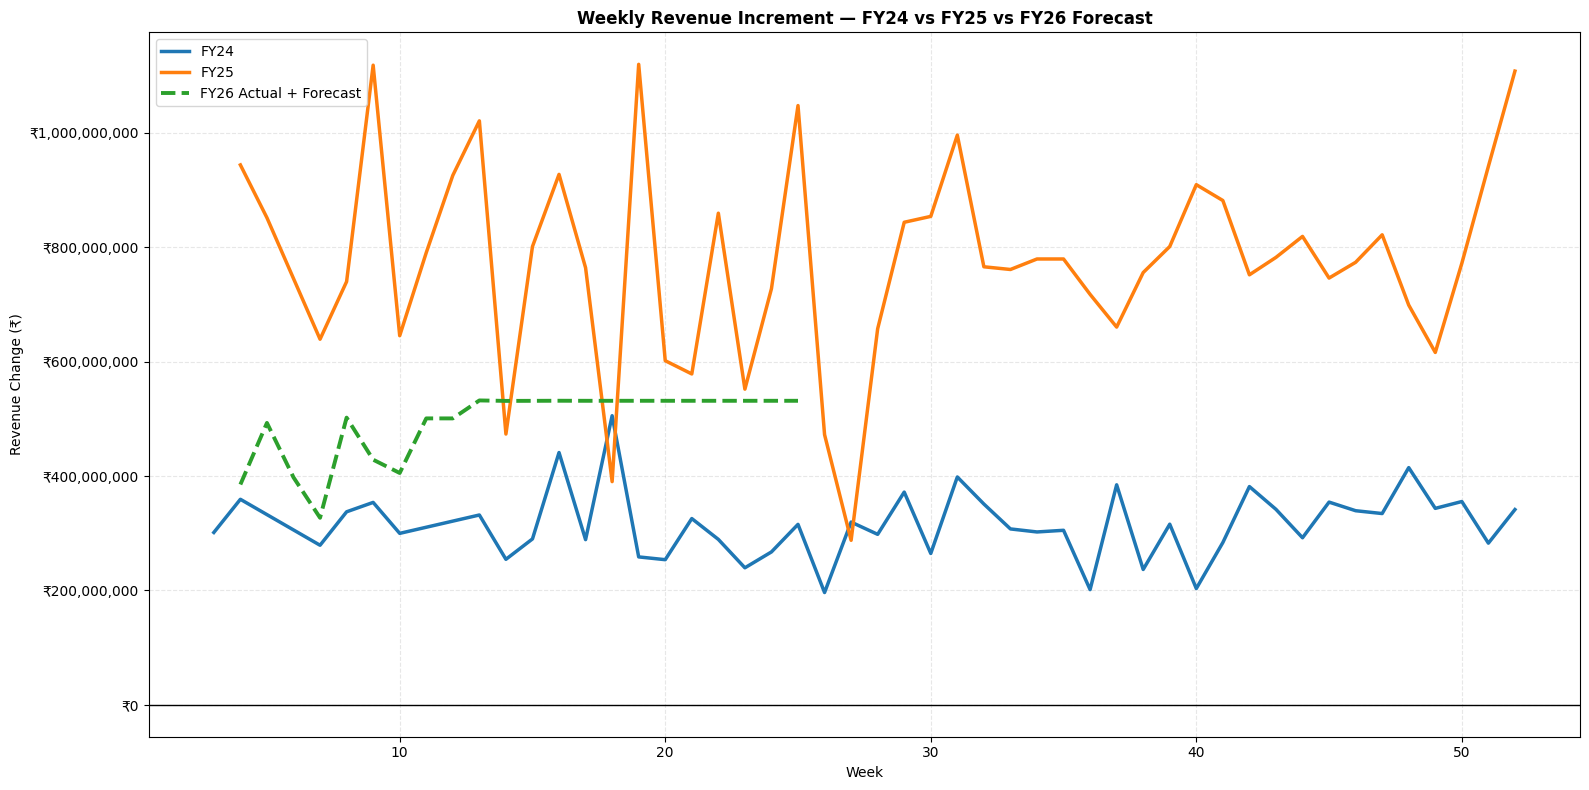

In [82]:
plt.figure(figsize=(16,8))

plt.plot(inc_df["Week"], inc_df["FY24_Weekly_Inc"], label="FY24", linewidth=2.5)
plt.plot(inc_df["Week"], inc_df["FY25_Weekly_Inc"], label="FY25", linewidth=2.5)
plt.plot(inc_df_extended["Week"], inc_df_extended["FY26_Weekly_Inc"],
         label="FY26 Actual + Forecast", linestyle="--", linewidth=2.8)

plt.axhline(0, color="black", linewidth=1)

plt.gca().yaxis.set_major_formatter(
    mtick.StrMethodFormatter("₹{x:,.0f}")
)

plt.title("Weekly Revenue Increment — FY24 vs FY25 vs FY26 Forecast", weight="bold")
plt.xlabel("Week")
plt.ylabel("Revenue Change (₹)")
plt.legend()
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


In [84]:
week_fy_table = pd.concat([

    # ---------- FY24 ----------
    pd.DataFrame({
        "Week": inc_df["Week"],
        "FY": "FY24",
        "FYTD_Revenue": inc_df["FY24_FYTD"],
        "Weekly_Increment": inc_df["FY24_Weekly_Inc"],
        "WoW_%": inc_df["FY24_WoW_%"]
    }),

    # ---------- FY25 ----------
    pd.DataFrame({
        "Week": inc_df["Week"],
        "FY": "FY25",
        "FYTD_Revenue": inc_df["FY25_FYTD"],
        "Weekly_Increment": inc_df["FY25_Weekly_Inc"],
        "WoW_%": inc_df["FY25_WoW_%"]
    }),

    # ---------- FY26 ----------
    pd.DataFrame({
        "Week": inc_df["Week"],
        "FY": "FY26",
        "FYTD_Revenue": inc_df["FY26_FYTD"],
        "Weekly_Increment": inc_df["FY26_Weekly_Inc"],
        "WoW_%": inc_df["FY26_WoW_%"]
    })

], ignore_index=True)


In [85]:
week_fy_table = (
    week_fy_table
    .sort_values(["FY", "Week"])
    .reset_index(drop=True)
)


In [86]:
week_fy_table.head(12)


,Week,FY,FYTD_Revenue,Weekly_Increment,WoW_%
0,1,FY24,NaN,NaN,NaN
1,2,FY24,"595,146,955.74",NaN,NaN
2,3,FY24,"896,384,585.76","301,237,630.02",NaN
3,4,FY24,"1,255,661,249.62","359,276,663.86",0.19
4,5,FY24,NaN,"332,483,894.08",-0.07
5,6,FY24,"2,007,916,702.01","305,691,124.29",-0.08
6,7,FY24,"2,286,815,056.52","278,898,354.51",-0.09
7,8,FY24,"2,624,209,199.40","337,394,142.88",0.21
8,9,FY24,"2,978,040,295.93","353,831,096.53",0.05
9,10,FY24,"3,277,722,262.99","299,681,967.06",-0.15


In [94]:
week_fy_raw["FY25"] = week_fy_raw["FY25"] / 2


In [95]:
weekly_raw = (
    df.groupby(["Year", "Week"])["ANSR / Tech Revenue FYTD"]
      .sum()
      .reset_index()
)

weekly_raw = weekly_raw[weekly_raw["Week"].between(1, 52)]

fy24 = weekly_raw[weekly_raw["Year"].astype(str).str.contains("24")][
    ["Week", "ANSR / Tech Revenue FYTD"]
].rename(columns={"ANSR / Tech Revenue FYTD": "FY24"})

fy25 = weekly_raw[weekly_raw["Year"].astype(str).str.contains("25")][
    ["Week", "ANSR / Tech Revenue FYTD"]
].rename(columns={"ANSR / Tech Revenue FYTD": "FY25"})

fy26 = weekly_raw[weekly_raw["Year"].astype(str).str.contains("26")][
    ["Week", "ANSR / Tech Revenue FYTD"]
].rename(columns={"ANSR / Tech Revenue FYTD": "FY26"})

week_fy_raw = (
    pd.DataFrame({"Week": range(1, 53)})
    .merge(fy24, on="Week", how="left")
    .merge(fy25, on="Week", how="left")
    .merge(fy26, on="Week", how="left")
)

# ✅ Divide FY25 by 2
week_fy_raw["FY25"] = week_fy_raw["FY25"] / 2

week_fy_raw.head(52)


,Week,FY24,FY25,FY26
0,1,NaN,NaN,NaN
1,2,"595,146,955.74","21,561,262,428.67",NaN
2,3,"896,384,585.76","916,453,684.77","966,836,957.51"
3,4,"1,255,661,249.62","1,388,515,070.95","1,352,008,364.07"
4,5,NaN,"1,814,370,518.34","1,844,864,435.29"
5,6,"2,007,916,702.01","2,187,089,504.72","2,242,474,275.42"
6,7,"2,286,815,056.52","2,506,723,435.68","2,569,416,301.04"
7,8,"2,624,209,199.40","2,876,725,322.17","3,071,510,031.32"
8,9,"2,978,040,295.93","3,436,012,092.86","3,500,054,996.89"
9,10,"3,277,722,262.99","3,758,708,867.99","3,905,335,926.80"


In [97]:
week_fy_raw.to_csv(
    "Weekly_Revenue.csv",
    index=False
)
